<a href="https://colab.research.google.com/github/bigvisionai/upgrad_alumni_workshop_day2/blob/master/face_recognition/OpenCV_DNN_Face_Detection_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## OpenCV DNN based Face Detection and Recognition

FaceDetectorYN and FaceRecongizerSF classes were introduced to OpenCV very recently with the release 4.5.4.  Compared to other systems like [FaceNet](https://arxiv.org/pdf/1503.03832.pdf), it is very fast, accurate and hence suitable for real time applications. In this method, the face matching is performed through the following steps.

 - Face Detection
 - Face Align and Crop
 - Feature Extraction
 - Recognition

<img src="https://learnopencv.com/wp-content/uploads/2022/03/face-recognition.jpg" alt="Face detection and recognition">

Face Detection: [YuNet](https://github.com/opencv/opencv_zoo/tree/master/models/face_detection_yunet)

Face Recognition: [SFace: Sigmoid-Constrained Hypersphere Loss for Robust Face Recognition](https://github.com/opencv/opencv_zoo/tree/master/models/face_recognition_sface)

In [ ]:
if 'google.colab' in str(get_ipython()):
    print("Downloading Code to Colab Environment")
    !wget https://www.dropbox.com/sh/d1f0zadon1ffpue/AADTRTxWKD501zizH6vaaTORa?dl=1 -O code.zip -q --show-progress
    !unzip -qq code.zip
    !pip install --upgrade opencv-contrib-python
else:
    pass

### 1. Import Libraries

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

### 2. Global Constants

 - The similarity threshold values are used while face recognition.
 - `score_threshold`, `nms_threshold`, and `top_k` values are used while creating he detector and the recognizer.

In [ ]:
# Similarity thresholds.
cosine_similarity_thresh = 0.363
l2_similarity_thresh = 1.128

# Initializations parameters.
score_threshold = 0.9
nms_threshold = 0.3
top_k = 5000

# Colors.
blue = (255, 0, 0)
green = (0, 255, 0)
red = (0, 0, 255)
yellow = (0, 255, 255)
cyan = (255, 0, 255)

### 3. Display Detections Function

The `faces` matrix is obtained from the detector. For each detected face, we get 14 coordinates. Top left corner is coordinate 0, 1, coordinate 2, 3 gives width, height and rest of the points are 5 face landmarks.
 - Eyes
 - Nose
 - Lip corners

### 4. Download Models and Images


In [ ]:
!wget https://github.com/opencv/opencv_zoo/raw/master/models/face_detection_yunet/face_detection_yunet_2021dec.onnx
!wget https://github.com/opencv/opencv_zoo/raw/master/models/face_recognition_sface/face_recognition_sface_2021dec.onnx

!wget https://learnopencv.com/wp-content/uploads/2022/03/musk1.jpg
!wget https://learnopencv.com/wp-content/uploads/2022/03/musk2.jpg
!wget https://learnopencv.com/wp-content/uploads/2022/03/jeff1.jpg

### 5. Display Detections
This functions renders bounding box and five landmarks on the detected face.

In [ ]:
def display_detections(im, faces, radius=2, thickness=2):
    if faces[1] is not None:
        for idx, face in enumerate(faces[1]):           
            coords = face[:-1].astype(np.int32)
            tlc = (coords[0], coords[1])
            brc = (coords[0]+coords[2], coords[1]+coords[3])
            cv2.rectangle(im, tlc, brc, green, thickness)
            cv2.circle(im, (coords[4], coords[5]), radius, blue, -1)
            cv2.circle(im, (coords[6], coords[7]), radius, red, -1)
            cv2.circle(im, (coords[8], coords[9]), radius, green, -1)
            cv2.circle(im, (coords[10], coords[11]), radius, cyan, -1)
            cv2.circle(im, (coords[12], coords[13]), radius, yellow, -1)
    return im

### 6. Extract Features

We pass the image through the detector to get the coordinates of the face landmarks and the bounding box. This function returns the coordinates, the cropped face and the features of the detected faces.


In [ ]:
def extractFeatures(img):
    # Image size.
    img_height, img_width = img.shape[:2]
    # Set detector input size.
    detector.setInputSize((img_width, img_height))
    # Perform detection.
    faces = detector.detect(img)
    # Align and crop faces.
    face_align = recognizer.alignCrop(img, faces[1][0])
    # Extract features.
    face_features = recognizer.feature(face_align)
    
    return faces, face_align, face_features

### 7. Function to print result

In [ ]:
def results(cos, l2):
    if (cos >= cosine_similarity_thresh):
        text = "Same Person"
    else:
        text = "Different Person"

    print('Cosine Similarity Method : {}'.format(text))
    print('Threshold : ', cosine_similarity_thresh)
    print('Cosine score : ', round(cos, 4))


    if(l2 <= l2_similarity_thresh):
        text = "Same Person"
    else:
        text = "Different Person"

    print('\n')
    print('l2 Similarity Method : {}'.format(text))
    print('Threshold : ', l2_similarity_thresh)
    print('l2 score : ', round(l2, 4))

### 8. Initialization
#### 8.1 Detector Function Syntax
```
retval = cv.FaceDetectorYN.create(model, config, input_size, score_threshold, nms_threshold, top_k, backend_id, target_id)
```
The detector has **three required parameters**.
 - `model` : Path to the model file
 - `config` : Not required for ONNX model. Added for compaitibility.
 - `input_size` : The input size of the image accpted by the network. 


**Optional parameters(five).**

 - `score_threshold` : the threshold to filter out bounding boxes of score smaller than the given value. Default value is 0.9.
 - `nms_threshold` : the threshold to suppress bounding boxes of IoU bigger than the given value. Default value is 0.3.
 - `top_k` : Number of top boxes to keep before Non-Maximum suppression. Default is 5000.

The `backend_id` and `target_id` are also optional parameters with default value 0, 0 respectively.

In [ ]:
# Model paths.
face_detection_model = 'face_detection_yunet_2021dec.onnx'
face_recognition_model = 'face_recognition_sface_2021dec.onnx'

# Detector.
detector = cv2.FaceDetectorYN.create(face_detection_model, "", (320, 320), score_threshold, nms_threshold, top_k)

#### 8.2 Recognizer Function Syntax

```
retval = cv2.FaceRecognizerSF.create(model, config, backend_id, target_id)
```

It has **two required parameters**, `model` and the `config` file. However, ONNX model does not need config file. The `backend_id` and `target_id` are **optional parameters** with default value 0, 0 respectively.

In [ ]:
# Recognizer.
recognizer = cv2.FaceRecognizerSF.create(face_recognition_model, "")

### 9. Test1 : Elon Musk

#### 9.1 Load Images

In [ ]:
# Load images for comparison.
img1 = cv2.imread("musk1.jpg")
img2 = cv2.imread("musk2.jpg")

# Get height and width.
img1_height, img1_width = img1.shape[:2]
img2_height, img2_width = img2.shape[:2]

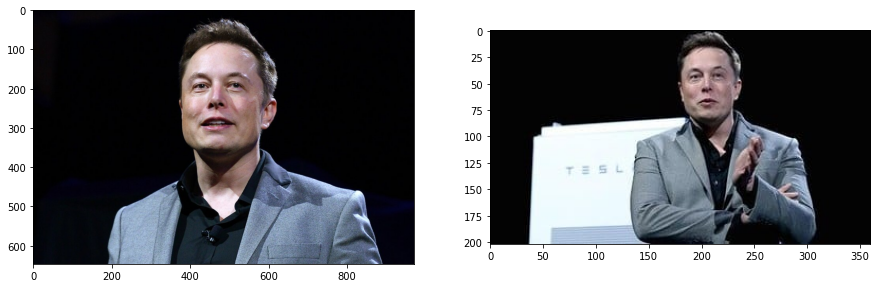

In [ ]:
plt.figure(figsize=(15,10))
plt.subplot(121); plt.imshow(img1[...,::-1]);
plt.subplot(122); plt.imshow(img2[...,::-1]);

#### 9.2 Extract Landmark and Features.

In [ ]:
faces1, face_align1, face1_features = extractFeatures(img1)
faces2, face_algn2, face2_features = extractFeatures(img2)

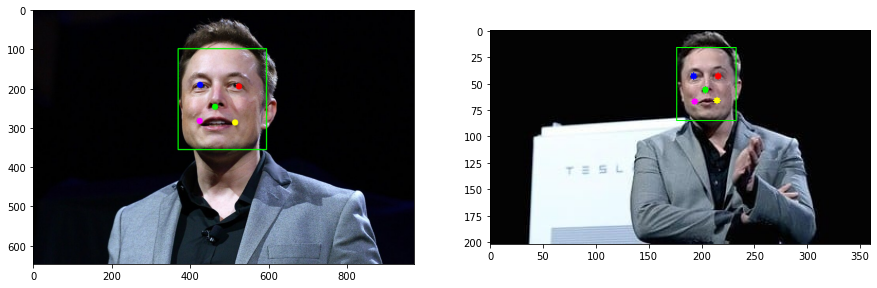

In [ ]:
# Display.
imgA = display_detections(img1.copy(), faces1, 8, 2)
imgB = display_detections(img2.copy(), faces2, 3, 1)
plt.figure(figsize=(15,10))
plt.subplot(121); plt.imshow(imgA[...,::-1]);
plt.subplot(122); plt.imshow(imgB[...,::-1]);

#### 9.3 Match Features
The `match` method takes **features** of both the images and returns distance between the features. The third parameter is optional with the default type being `FR_COSINE`. The other existing method is `FR_NORM_L2`.

For cosine score, higher value means higher similarity. The maximum value can be 1.0. On the other hand, lower l2 score means higher similarity. Possible minimum value is 0.0.

In [ ]:
cosine_score = recognizer.match(face1_features, face2_features, cv2.FaceRecognizerSF_FR_COSINE)
l2_score = recognizer.match(face1_features, face2_features, cv2.FaceRecognizerSF_FR_NORM_L2)

In [ ]:
results(cosine_score, l2_score)

Cosine Similarity Method : Same Person
Threshold :  0.363
Cosine score :  0.8474


l2 Similarity Method : Same Person
Threshold :  1.128
l2 score :  0.5525


### 10. Test2 : Elon Musk and Jeff Bezos

#### 10.1 Load Images

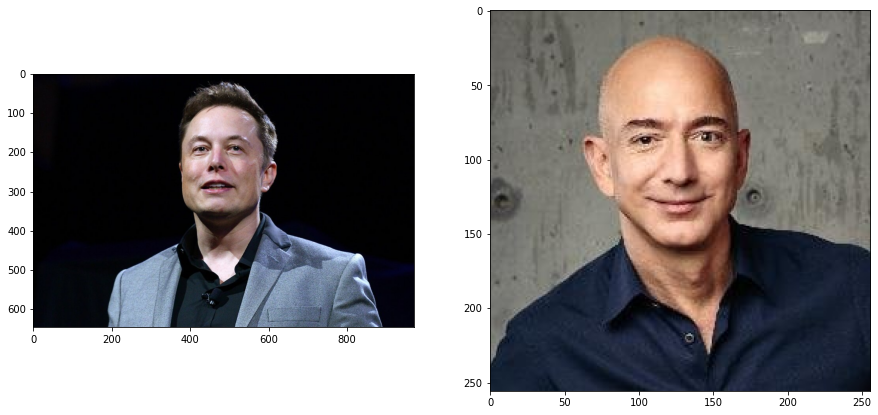

In [ ]:
img2 = cv2.imread('jeff1.jpg')
plt.figure(figsize=(15,10))
plt.subplot(121); plt.imshow(img1[...,::-1]);
plt.subplot(122); plt.imshow(img2[...,::-1]);

#### 10.2 Extract Landmark and Features.


In [ ]:
faces1, face_align1, face1_features = extractFeatures(img1)
faces2, face_align2, face2_features = extractFeatures(img2)

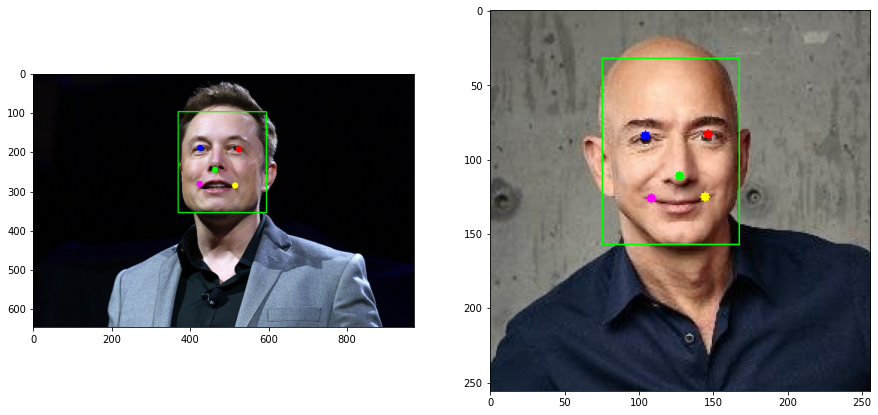

In [ ]:
# Display.
imgA = display_detections(img1.copy(), faces1, 8, 2)
imgB = display_detections(img2.copy(), faces2, 3, 1)
plt.figure(figsize=(15,10))
plt.subplot(121); plt.imshow(imgA[...,::-1]);
plt.subplot(122); plt.imshow(imgB[...,::-1]);

#### 10.3 Match Features

In [ ]:
cosine_score = recognizer.match(face1_features, face2_features, cv2.FaceRecognizerSF_FR_COSINE)
l2_score = recognizer.match(face1_features, face2_features, cv2.FaceRecognizerSF_FR_NORM_L2)

In [ ]:
# Print results.
results(cosine_score, l2_score)

Cosine Similarity Method : Different Person
Threshold :  0.363
Cosine score :  0.2103


l2 Similarity Method : Different Person
Threshold :  1.128
l2 score :  1.2568


### Conclusion
- Works for images as small as 10x10 pixels
- Smaller but faster model
- Works in real time